# Active Learning on the Decision Tree classifier

Now that the data is preprocessed we can start with our actual experiments.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import pipeline, preprocessing

%load_ext autoreload
%autoreload 2
from Methods import*

First we need to read in the dataframe where we categorize the target in numbers and get the input features and labels

In [2]:
#read in dataframe
data = pd.read_csv('dataset_1.csv')

#define the target and categorize it in numbers
target = 'PROFILE'
profile_options = np.unique(data['PROFILE'])
for index, profile in enumerate(profile_options):
    data.loc[data['PROFILE'] == profile,'PROFILE'] = index

#then get your input features and labels
X = np.array(data.drop(target, axis=1).values.tolist())
y_true = np.array(data[target]).astype('int')

Now we have extracted our features and labels and we can start our little experiment. The experiment goes as follows:

1) First we apply cross-validation on the classifier without tuning the hyperparameters.

2) We first just get a model and accuracy for the classifier without tuning the hyperparameters. 

3) Then we tune the hyperparameters of our classifier with the nested cross validation grid search.

4) Then we split out data into a training set and a test set.

5) We apply the active learning algorithm for different active learning methods by using a batch size of 100 for each active learning cycle. Then we run the algorithm so that after a certain amount of cycles we get to the training set. Then we compare these results for every active learning method to the classifier without using active learning. The model architecture and hyperparameters are all the same for every method.

6) We do this for both the classifier with and without tuning the hyperparameters.

Now that our experiment is thought through, we can start

### 1-2) Applying cross-validation on the classifier without tuning the hyperparameters

In [3]:
def cross_validation(X, y, folds, clf):
    skf = StratifiedKFold(n_splits=folds)
    bal_accs = []
    for i, (train_index, test_index) in enumerate(skf.split(X,y)):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        bal_acc = balanced_accuracy(y_pred, y_test)
        bal_accs.append(bal_acc)
    print(f"Avg balanced accuracy: {np.mean(bal_accs):.3f}")
    print()

In [4]:
print('Decision Tree')
clf = pipeline.Pipeline([('sc', StandardScaler()), 
                         ('tree', DecisionTreeClassifier())])
cross_validation(X, y_true, 5, clf)

Decision Tree
Avg balanced accuracy: 0.675



### 3) Tuning the Hyperparameters
TO DO: normaal de nested_cv gebruiken maar kan nog geen best parameters printen

In [5]:
def grid_search(X, y, model, p_grid):
    cv = KFold(n_splits=5, shuffle=True, random_state=0)
    clf = GridSearchCV(estimator=model, param_grid=p_grid, scoring="balanced_accuracy", cv=cv)
    clf.fit(X, y)
    print(f"Best score: {clf.best_score_:.4f}")
    print(f"Best params: {clf.best_params_}")
    return clf.best_params_
    
def nested_cv(X, y, model, p_grid):
    inner_cv = KFold(n_splits=5, shuffle=True, random_state=0)
    outer_cv = KFold(n_splits=5, shuffle=True, random_state=0)
    
    clf = GridSearchCV(estimator=model, param_grid=p_grid, cv=inner_cv)
    nested_score = cross_val_score(clf, X, y, cv=outer_cv)
    return nested_score.mean()

In [6]:
print("Decision Tree")
clf = pipeline.make_pipeline(StandardScaler(), DecisionTreeClassifier(random_state=0))
best_param_dt = grid_search(X, y_true, clf, {"decisiontreeclassifier__criterion": ["gini", "entropy"], "decisiontreeclassifier__max_depth": [3, 4, 5, None]})

Decision Tree
Best score: 0.6808
Best params: {'decisiontreeclassifier__criterion': 'entropy', 'decisiontreeclassifier__max_depth': None}


### 4) Splitsing in Training and Testing set

In [7]:
X_train,X_test,y_train,y_test = train_test_split(X,y_true,test_size = 0.25)

In [8]:
print('Length of the training set: '+str(len(X_train)))

Length of the training set: 2250


### 5) Apply Active Learning
Daarvoor normaliseren we eerst de data

In [9]:
print(X_train)

[[34. 35. 31. ... 64. 80. 94.]
 [60. 39.  0. ... 59. 49. 52.]
 [17. 57. 14. ... 68. 69. 76.]
 ...
 [ 0. 61. 46. ... 45. 76. 27.]
 [17. 36. 27. ... 89. 62. 72.]
 [28. 33. 15. ... 71. 71. 87.]]


In [10]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
print(X_train_scaled)

[[-0.17649624 -0.37627562 -0.2920074  ... -0.05178556  0.9097813
   1.84549639]
 [ 0.95949562 -0.19280609 -1.79681098 ... -0.40876322 -1.26751311
  -1.07591354]
 [-0.91926015  0.63280679 -1.11722227 ...  0.23379657  0.13719296
   0.59346356]
 ...
 [-1.66202406  0.81627632  0.43612336 ... -1.40830066  0.62884008
  -2.81484803]
 [-0.91926015 -0.33040824 -0.48617561 ...  1.73310274 -0.35445416
   0.31523404]
 [-0.43864821 -0.46801038 -1.06868022 ...  0.44798316  0.27766357
   1.35859473]]


In [11]:
print(len(X_train_scaled))
print(len(y_train))

2250
2250


In [12]:
def plot_AL(cycle, accuracies, qs_name, clf_name):
    plt.plot(cycle, accuracies, label = qs_name)
    plt.xlabel('Labeled samples')
    plt.ylabel('Accuracy')
    plt.title(clf_name)
    plt.legend()
    plt.show()

Decision Tree


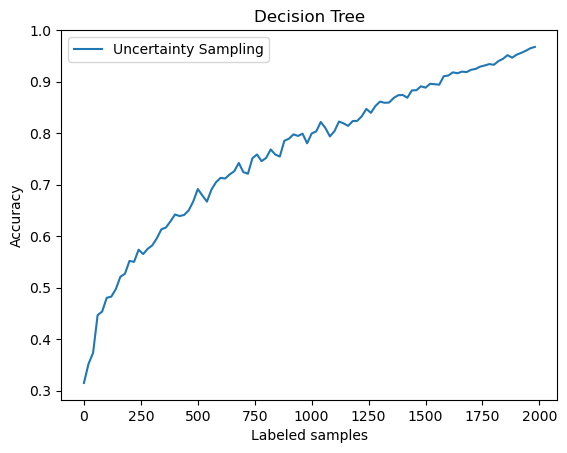

In [13]:
print('Decision Tree')
clf = SklearnClassifier(DecisionTreeClassifier(criterion = 'entropy'), classes=np.unique(y_true))
clf_name = 'Decision Tree'
qs = UncertaintySampling(method='entropy')
qs_name = 'Uncertainty Sampling'
cycle, accuracies, indep_accuracies = ActiveLearning_UncertaintySampling(X_train_scaled, X_test_scaled, y_train, y_test, 100, 20, clf)
plot_AL(cycle, accuracies, qs_name, clf_name)

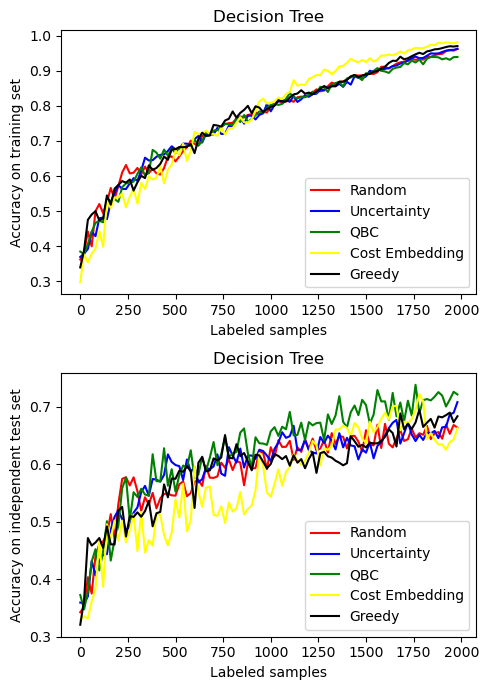

In [14]:
clf_name = 'Decision Tree'
colors = ['blue', 'red', 'green']
fig, ax = plt.subplots(2, figsize=(5, 7))

clf = SklearnClassifier(DecisionTreeClassifier(criterion = 'entropy'), classes=np.unique(y_true))
cycle, accuracies, indep_accuracies = ActiveLearning_RandomSampling(X_train_scaled, X_test_scaled, y_train, y_test, 100, 20, clf)
ax[0].plot(cycle, accuracies, color = 'red', label = 'Random')
ax[1].plot(cycle, indep_accuracies, color = 'red', label = 'Random')

clf = SklearnClassifier(DecisionTreeClassifier(criterion = 'entropy'), classes=np.unique(y_true))
cycle, accuracies, indep_accuracies = ActiveLearning_UncertaintySampling(X_train_scaled, X_test_scaled, y_train, y_test, 100, 20, clf)
ax[0].plot(cycle, accuracies, color = 'blue', label = 'Uncertainty')
ax[1].plot(cycle, indep_accuracies, color = 'blue', label = 'Uncertainty')

clf = SklearnClassifier(DecisionTreeClassifier(criterion = 'entropy'), classes=np.unique(y_true))
cycle, accuracies, indep_accuracies = ActiveLearning_QueryByCommittee(X_train_scaled, X_test_scaled, y_train, y_test, 100, 20, clf)
ax[0].plot(cycle, accuracies, color = 'green', label = 'QBC')
ax[1].plot(cycle, indep_accuracies, color = 'green', label = 'QBC')

clf = SklearnClassifier(DecisionTreeClassifier(criterion = 'entropy'), classes=np.unique(y_true))
cycle, accuracies, indep_accuracies = ActiveLearning_CostEmbeddingAL(X_train_scaled, X_test_scaled, y_train, y_test, 100, 20, clf)
ax[0].plot(cycle, accuracies, color = 'yellow', label = 'Cost Embedding')
ax[1].plot(cycle, indep_accuracies, color = 'yellow', label = 'Cost Embedding')

clf = SklearnClassifier(DecisionTreeClassifier(criterion = 'entropy'), classes=np.unique(y_true))
cycle, accuracies, indep_accuracies = ActiveLearning_GreedySamplingX(X_train_scaled, X_test_scaled, y_train, y_test, 100, 20, clf)
ax[0].plot(cycle, accuracies, color = 'black', label = 'Greedy')
ax[1].plot(cycle, indep_accuracies, color = 'black', label = 'Greedy')

ax[0].set(xlabel='Labeled samples', ylabel='Accuracy on training set', title=clf_name)
ax[1].set(xlabel='Labeled samples', ylabel='Accuracy on independent test set', title=clf_name)
ax[0].legend()
ax[1].legend()
plt.tight_layout()
plt.show()

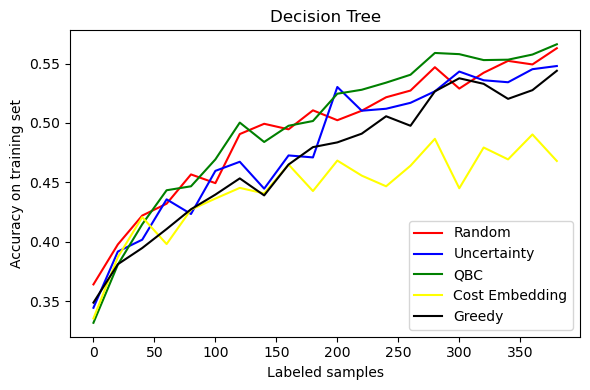

In [16]:
clf = SklearnClassifier(DecisionTreeClassifier(criterion = 'entropy'), classes=np.unique(y_true))
clf_name = 'Decision Tree'
n_samples = 20
batch_size = 20
folds = 5
colors = ['blue', 'red', 'green']

fig, ax = plt.subplots(figsize=(6, 4))

clf = SklearnClassifier(DecisionTreeClassifier(criterion = 'entropy'), classes=np.unique(y_true))
cycle, accuracies = ActiveLearning_CrossValidation(X, y_true, folds, ActiveLearning_RandomSampling, n_samples, batch_size, clf)
ax.plot(cycle, accuracies, color = 'red', label = 'Random')

clf = SklearnClassifier(DecisionTreeClassifier(criterion = 'entropy'), classes=np.unique(y_true))
cycle, accuracies = ActiveLearning_CrossValidation(X, y_true, folds, ActiveLearning_UncertaintySampling, n_samples, batch_size, clf)
ax.plot(cycle, accuracies, color = 'blue', label = 'Uncertainty')

clf = SklearnClassifier(DecisionTreeClassifier(criterion = 'entropy'), classes=np.unique(y_true))
cycle, accuracies = ActiveLearning_CrossValidation(X, y_true, folds, ActiveLearning_QueryByCommittee, n_samples, batch_size, clf)
ax.plot(cycle, accuracies, color = 'green', label = 'QBC')

clf = SklearnClassifier(DecisionTreeClassifier(criterion = 'entropy'), classes=np.unique(y_true))
cycle, accuracies = ActiveLearning_CrossValidation(X, y_true, folds, ActiveLearning_CostEmbeddingAL, n_samples, batch_size, clf)
ax.plot(cycle, accuracies, color = 'yellow', label = 'Cost Embedding')

clf = SklearnClassifier(DecisionTreeClassifier(criterion = 'entropy'), classes=np.unique(y_true))
cycle, accuracies = ActiveLearning_CrossValidation(X, y_true, folds, ActiveLearning_GreedySamplingX, n_samples, batch_size, clf)
ax.plot(cycle, accuracies, color = 'black', label = 'Greedy')

ax.set(xlabel='Labeled samples', ylabel='Accuracy with CV', title=clf_name)
ax.legend()
plt.tight_layout()
plt.show()